#Surf's Up Climate and Station Analysis with SQl Alchemy

First Let's Import Dependencies

In [269]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd
from datetime import timedelta , datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM
#Create an engine object on our SQL Lite Database and store relevant items for later use (Base, tables, inspector)

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
inspector = inspect(engine)

In [14]:
inspector.get_table_names()

['measurement', 'station']

In [15]:
meas_col = inspector.get_columns('measurement')

for col in meas_col:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
station_col = inspector.get_columns('station')
for col in station_col:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [ ]:
#The instructions asked for a query of the last 12 months of data but before that we need to explore the date ranges

In [141]:
#Max Date and then base the query 12 months from that date
max_date = max(session.query(Measurement.date))
print(max_date)
print(max_date[0])
#Need to format the date nicely so it can go into our query
max_date_1 = max_date[0]

('2017-08-23',)
2017-08-23


In [158]:
# Calculate the date 1 year ago from today
max_date_1 = dt.strptime(max_date[0], "%Y-%m-%d")
print(max_date_1)
one_year_ago_date = max_date_1 - timedelta(days=365)
print(one_year_ago_date)

2017-08-23 00:00:00
2016-08-23 00:00:00


In [311]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
L12M_Data = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date > one_year_ago_date).group_by(Measurement.date).order_by(Measurement.date).all()

len(L12M_Data)

365

In [ ]:
#Now let's query the sqllite database and store as a data frame

In [180]:
df_2 = pd.DataFrame(L12M_Data).set_index('date')

df_2['prcp'] =  df_2['prcp'].fillna(0)

df_2.head()

,prcp
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,0.00
2016-08-28,2.07


In [187]:
# We set our index to date but we will need to plot it later; tolist method allows us to convert to an array for ease of 
#use later on

dates_array = df_2.index.tolist()
print(len(dates_array))

365


In [214]:
##Since our plot needs to show a month (days are too small) we need to store months into a list; many
#ways to do this but using a for loop into a list. 
# for loop to create a unique months list for our plot

date_mths =  []
for date in dates_array:
    date = dt.strptime(date,'%Y-%m-%d').strftime('%B')
    if date not in date_mths:
        date_mths.append(date)

        
print(date_mths)

['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']


In [219]:
#Create an array which we can use as x_axis days
xaxis_days = np.arange(0,len(dates_array), step = 31)

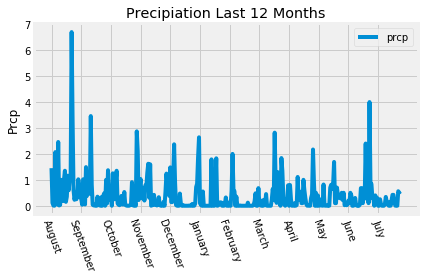

In [222]:
#plot the last 12 months of rainfall data 
ax = plt.axes()
plt.xticks(xaxis_days,date_mths, rotation = 290)
plt.plot(dates_array,df_2['prcp'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc = 'best')
plt.ylabel('Prcp')
plt.title('Precipiation Last 12 Months')
#need to use a tight layout since the months were being cutoff in the png file
plt.tight_layout()
plt.savefig('Precipitation Last 12 Months')



In [247]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_2.describe(include = 'all')

,prcp
count,365.000000
mean,0.406493
std,0.691942
min,0.000000
25%,0.000000
50%,0.110000
75%,0.530000
max,6.700000


#Stations Analytics

In [250]:
meas_col = inspector.get_columns('measurement')

for col in meas_col:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [304]:
# How many stations are available in this dataset?
stations = pd.DataFrame(engine.execute("SELECT * from Measurement").fetchall())
stations = stations.rename(columns = {0: "ID",1:"Station",2:"Date",3: "Prcp",4:"Tobs"})
stations.head()

print(f"There are {len(stations['Station'].unique())} unique stations in the data set" )


There are 9 unique stations in the data set


In [305]:
# What are the most active stations?
# List the stations and the counts in descending order.
grouped = stations.groupby(by = 'Station').count().reset_index()
grouped.sort_values('Tobs', ascending = False)

,Station,ID,Date,Prcp,Tobs
6,USC00519281,2772,2772,2772,2772
7,USC00519397,2724,2724,2685,2724
1,USC00513117,2709,2709,2696,2709
8,USC00519523,2669,2669,2572,2669
3,USC00516128,2612,2612,2484,2612
2,USC00514830,2202,2202,1937,2202
0,USC00511918,1979,1979,1932,1979
4,USC00517948,1372,1372,683,1372
5,USC00518838,511,511,342,511


In [306]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
df_MostActive = stations[stations['Station'] == 'USC00519281']
df_MostActive_MinTemp = df_MostActive['Tobs'].min()
df_MostActive_MaxTemp = df_MostActive['Tobs'].max()
df_Most_Active_AvgTemp = df_MostActive['Tobs'].mean()

print(f'For Station UCS00519281, the lowest temp was {df_MostActive_MinTemp}; \
the highest temp was {df_MostActive_MaxTemp} and the average temp was \
{df_Most_Active_AvgTemp}')

For Station UCS00519281, the lowest temp was 54.0; the highest temp was 85.0 and the average temp was 71.66378066378067


Text(0.5,1,'Histogram for Most Active Station UCS00519281')

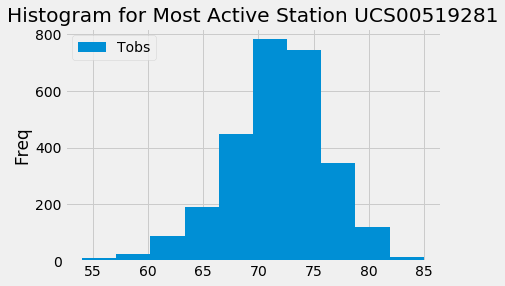

In [307]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
#plot the results as a histogram
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.hist(df_MostActive['Tobs'])
handles, labels = ax.get_legend_handles_labels()
lgd =ax.legend(handles, labels, loc = 'upper left')
plt.ylabel('Freq')
plt.title('Histogram for Most Active Station UCS00519281')



In [310]:
#Climate App

app = Flask(__name__)

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitatipn<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobss<br/>"
        f"/api/v1.0/start<br/>"
        f"/api/v1.0/end<br/>"
    )


@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return a dict for temp and dates over the last year"""
    # Query all passengers
    results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date > one_year_ago_date).group_by(Measurement.date).order_by(Measurement.date).all()

    # Create a dictionary from the row data and append to a list of all dates/temps
    date_temps = []
    for date in results:
        temp_dict = {}
        temp_dict["date"] = Measurement.date
        temp_dict["prcp"] = Measurement.prcp
        
        date_temps.append(temp_dict)

    return jsonify(date_temps)
    


@app.route("/api/v1.0/stations")
def stations():
    """Returns unique stations"""
    # Query all passengers
    results = stations = pd.DataFrame(engine.execute("SELECT * from Measurement").fetchall())    
    return jsonify(stations['Station'].unique())

#Climate App


@app.route("/api/v1.0/tobs")
def tobs():
    """Return temp and dates over the last year"""
    # Query all passengers
    tobs = pd.DataFrame(engine.execute("SELECT date, tobs from Measurement").fetchall())   
    return jsonify(tobs)


@app.route("/api/v1.0/start")
def start():
    """Return a dict for temp and dates over the last year"""
    # Query all passengers
    results = stations = pd.DataFrame(engine.execute("SELECT * from Measurement").fetchall())    
    return jsonify(stations['Station'].unique())




if __name__ == "__main__":
    app.run(debug = True)


    

UnsupportedOperation: not writable

## Optional Challenge Assignment

In [30]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [34]:
# Plot the daily normals as an area plot with `stacked=False`
